# 6.8701 Homework 2: Protein Language Models and Structure

**Due: October 21 at 11:59 PM EDT**

This homework has three parts, focusing on protein language modeling and protein structure. The goal is to expose you to different tools and data that can help you in your final project. In particular you will be using:

- The ESM protein language model from Meta
- Multiple Sequence Alignments
- AlphaFold2/3
- Pymol

If you have any questions, please ask on piazza or at office hours!

Copy this notebook, and answer all questions directly in this notebook and complete the missing code where marked with **COMPLETE HERE**.

When you are done, submit the .ipynb file as well as PDF to Canvas.

## 0. Setup (run this)

In [ ]:
!pip install fair-esm scikit-learn biopython matplotlib torch pandas tqdm transformers

In [ ]:
#these are your file inputs
!wget -O train_esm6_data.pt https://www.dropbox.com/scl/fi/cf103vkoew0s5zys7920d/train_esm6_data.pt?rlkey=v7o2upz9txm0m284g6mgfq0ww&dl=0
!wget -O test_esm6_data.pt https://www.dropbox.com/scl/fi/v18bvl57eog1ysjb07nww/test_esm6_data.pt?rlkey=idc0y0nzwfizxxf75kyxbfxdh&dl=0
!wget -O train_esm150_data.pt https://www.dropbox.com/scl/fi/i4vazz4twcw38wzaykdq0/train_esm150_data.pt?rlkey=ev7tepsceqc4k5vbwsw5bsw67&dl=0
!wget -O test_esm150_data.pt https://www.dropbox.com/scl/fi/yyjk31urec4gdwk8ajppt/test_esm150_data.pt?rlkey=v8o5mzp608w8tmxywqmn4r3ob&dl=0
!wget -O blosum100.txt "https://drive.google.com/uc?export=download&id=1DvQJVzCEQWMm1pzaFpgl8SEPMfqIIUqY"
!wget -O aav_alignment.a2m "https://drive.google.com/uc?export=download&id=13-1rCMccfWvcUpFESBR6ubqsKNPrBNS6"
!wget -O aav_experiment.csv "https://drive.google.com/uc?export=download&id=1KMH8HXtKF8u7c8tHjS4S8Ht91p2neQBS"

import matplotlib.pyplot as plt
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import numpy as np
import esm
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
from Bio.PDB import PDBParser, PDBList
from google.colab import files
import os
from sklearn.decomposition import PCA
from transformers import EsmForMaskedLM, EsmTokenizer
from IPython.display import Image
from Bio.SVDSuperimposer import SVDSuperimposer

esm6_model, esm6_alphabet = esm.pretrained.esm2_t6_8M_UR50D()
esm6_model.eval()

esm150_model, esm150_alphabet = esm.pretrained.esm2_t30_150M_UR50D()
esm150_model.eval()

AA_NAME_MAP = {
  'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
  'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
  'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 'TER':'*',
  'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M','XAA':'X'
}

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt


## 1. Protein Language Models

In this problem we will explore protein language models. The goal is to give you some intuitions as to what these models learn during the pretraining process and how they can be used in downstream applications.

Protein language models like ESM are trained using the masked language modeling objective: given an input sequence, a subset of amino acids are masked and the model is tasked with predicting the masked tokens.

This process enables the models to capture complex relationships and patterns within protein sequences, which can be leveraged in a variety of downstream applications such as predicting protein structure, function, and interactions. Through our exploration, we will gain insights into what these models learn during their training.

### 1.A Amino Acid Embedding Representations

We explore the initial amino acid embeddings learned by Protein Language Models (PLMs). These embeddings are vectors from a lookup table that convert amino acid tokens into representations suitable for computational analysis. By examining these embeddings, we can understand how PLMs initially represent the biochemical properties of amino acids. It is important to note that while the term 'embeddings' often refers to the last hidden layer representation in other contexts, here we are discussing the initial lookup table vectors.

#### 1.A.1 Question

Here we provide you with a vector for each amino acid. Run a dimensionality reduction startegy (ex: t-SNE) to visualize the amino acids in 2D. The hypothesis is that some amino acids may be more "similar" to each other. You can use whatever method you see fit, but sklearn has a good TSNE package: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Note: when using the TSNE implementation above, you may want to use a small value for the perplexity, 3 seemed to work well.

You are given two ESM models to compare esm6 (esm2_t6_8M_UR50D) and esm150 (esm2_t30_150M_UR50D), both trained on Uniref50, but with 8M or 150M parameters, respectively. For more information about these models, you can check out: https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1.full.pdf


In [ ]:
# Create a dictionary mapping an amino acid to its vector
def get_aa_embeddings_esm(model, alphabet):
  """
  This function accesses the first embedding layer of the specified model to extract the embedding
  matrix. It then creates a dictionary mapping each amino acid token from the model's alphabet
  to its vector representation in the embedding matrix.

  Parameters:
  model (torch.nn.Module): The pretrained protein language model whose initial embedding layer
  contains the amino acid vectors.
  alphabet (esm.Alphabet): An Alphabet object that maps amino acid tokens to their indices
  within the embedding matrix.

  Returns:
  dict: A dictionary mapping amino acid tokens (str) to their corresponding embedding vectors
  (numpy.ndarray), extracted from the model's initial embedding layer.
  """
  embedding_matrix = model.embed_tokens.weight.data.numpy()
  aa_tokens = alphabet.standard_toks[:-2]
  aa_to_index = alphabet.to_dict()
  aa_to_embeddings = {aa: embedding_matrix[aa_to_index[aa]] for aa in aa_tokens}
  return aa_to_embeddings

esm6_aa_embeddings = get_aa_embeddings_esm(esm6_model, esm6_alphabet)
esm150_aa_embeddings = get_aa_embeddings_esm(esm150_model, esm150_alphabet)

def plot_tsne_embeddings(embeddings, **kwargs):
    """
    Performs dimensionality reduction on the given embeddings and plots the resulting 2D layout.

    This function is designed to be flexible, allowing adjustments and additional parameters as needed for
    specific t-SNE configurations or plotting customizations. You may find matplotlib helpful.

    Returns:
    None: This function only plots the results and does not return any value.
    """
    pass  # Implementation goes here

plot_tsne_embeddings(esm6_aa_embeddings)
plot_tsne_embeddings(esm150_aa_embeddings)

#### 1.A.2 Question

Amino acids are typically grouped by physiochemical properties, and these principles are often taught in biochemistry textbooks: https://cdn.technologynetworks.com/tn/images/body/aminoacids-pic3revised1574260662291.png

Comment on the TSNE plots. In particular, pick 2 clusters and identify what is similar about the amino acids in these clusters, based on the above chart or information you might find from other sources or wikipedia. How do the projections compare between the two models? Does this align with biochemical theory?

**Answer here**:

####  1.A.3 Question

Other common embedding techniques for amino acids are one-hot encoding or BLOSUM encoding. One-hot coding assumes no prior knowledge of the amino acids, representing amino acids by a vector where only one element is set to one and all other 19 amino acdis are zero. BLOck Substitution Matrix (BLOSUM) captures evolutionary substitutability. The BLOSUM amino acids embedding for a given amino acid is also length 20 (the row of values that represents its substitutability with each of  amino acids). Use the same dimensional reduction strategy to now visualize the BLOSUM100 embeddings in 2D.

In [ ]:
# Create a dictionary mapping an amino acid to its vector
def get_aa_embeddings_blosum():
  """
  Reads a BLOSUM100 matrix from a text file and converts it into a dictionary mapping each
  amino acid to its corresponding vector representation.

  Returns:
  dict: A dictionary where keys are amino acid characters (str) and values are their
        associated vector representations (numpy.ndarray) derived from the BLOSUM100 matrix.
  """
  embedding_matrix = pd.read_csv("blosum100.txt",delim_whitespace=True,header=0)
  aa_to_embeddings = {aa: embedding_matrix.values[index] for index, aa in enumerate(embedding_matrix.index)}
  return aa_to_embeddings

blosum_embedding = get_aa_embeddings_blosum()

plot_tsne_embeddings(blosum_embedding)

#### 1.A.4 Question

Comment on your observations. Pick 2 clusters and identify what is similar about the amino acids in these clusters. You may refer to Wikipedia and other sources for information regarding the chemical properties of amino acids.How do the projections compare between BLOSUM and ESM?

**Answer here**:

### 1.B Sequence-level embeddings

Explore sequence-level embeddings and apply them to build a simple classifier. Our goal is to predict the sub-cellular localization of proteins, focusing specifically on identifying whether a protein is a membrane protein.

Membrane proteins are integral to the cell's interactions with its environment and internal communications. They are embedded within the cellular membranes, including the plasma membrane that encloses the cell and the membranes of various organelles such as the mitochondria and endoplasmic reticulum. Membrane proteins play roles in various cellular processes including signal transduction, transport of molecules, and cell-cell recognition.

#### 1.B.1 Question

Sequence level embeddings were precomputed for you. You will train a classifier. Here you are welcome to train a more complex classifier, but the simplest approach would be to train a logistic regression model using sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

When using LogisticRegression, set C=10 and max_iter=1000 for best results.

Make sure to train on the training set, and evaluate your performance on the test set.



First load the embeddings (split into a training and test set). Train and test data is provided for both ESM6 and ESM150 models, train one classifier on each model and compare model performance on the test sets. Note that these two datasets are the same, but the sequence embedding vector depends on the esm model.

In [ ]:
# Loading the Dataset
# The datasets loaded below consist of lists of 2-tuples, each containing:
# 1. A learned representation (often referred to as an "embedding") of a protein sequence.
# 2. A boolean label (True/False) indicating whether the protein is a membrane protein.
train_esm6 = torch.load("/content/train_esm6_data.pt")
test_esm6 = torch.load("/content/test_esm6_data.pt")

train_esm150 = torch.load("/content/train_esm150_data.pt")
test_esm150 = torch.load("/content/test_esm150_data.pt")

Next, initialize and train the classifier on your training dataset. Here, you'll set up the logistic regression classifier using the given parameters: C=10 and max_iter=1000.

In [ ]:
def train_membrane_classifier(train_data, **kwargs):
    """
    Trains a classifier on protein sequence embeddings to predict membrane protein status.

    This function initializes and fits a model (which can be logistic regression, though alternatives
    are allowed) using the provided training data. The classifier is trained to distinguish between
    membrane and non-membrane proteins based on their learned embeddings, such as ESM-6 or ESM-150.

    Parameters:
    - train_data (list of tuples): A list where each element is a tuple containing:
        1. An embedding vector (np.ndarray) representing a protein sequence.
        2. A boolean label (True/False) indicating whether the protein is a membrane protein.

    Returns:
    - model: The trained (logistic regression or other) model. It should take in a tensor/matrix
      representation and return logits or probabilities of being a membrane protein or not.
    """
    raise NotImplementedError

model_on_esm6 = train_membrane_classifier(train_esm6)
model_on_esm150 = train_membrane_classifier(train_esm150)

 Now, predict and evaluate performance on test set. Now that the classifiers are trained, you can make predictions and evaluate each model on their test set using accuracy and ROC-AUC (from sklearn.metrics: https://scikit-learn.org/1.5/api/sklearn.metrics.html).

In [ ]:
def evaluate_model_performance(model, test_data):
    """
    Uses the provided trained model to make predictions on the test dataset,
    and then computes two performance metrics: accuracy and ROC-AUC score. Accuracy measures
    the proportion of correct predictions (both true positives and true negatives) while
    ROC-AUC score provides an aggregate measure of performance across all possible
    classification thresholds, focusing on the model's ability to distinguish between classes.

    Parameters:
    - model: The trained model, which should have a predict method for generating predictions
             and a predict_proba method for generating class probabilities.
    - test_data (list of tuples): A list where each element is a tuple containing:
        1. An embedding vector (np.ndarray) representing a protein sequence.
        2. A boolean label (True/False) indicating whether the protein is a membrane protein.

    Returns:
    - accuracy (float): The fraction of correctly classified samples.
    - roc_auc (float): The ROC-AUC score indicating the model's ability to discriminate between
                       the classes.

    """
    pass

    accuracy_ESM6 = ##
    print(f"Accuracy ESM6: {accuracy_ESM6:.4f}")

    roc_auc_ESM6 = ##
    print(f"ROC-AUC ESM6: {roc_auc_ESM6:.4f}")

    accuracy_ESM150 = ##
    print(f"Accuracy ESM150: {accuracy_ESM150:.4f}")

    roc_auc_ESM150 = ##
    print(f"ROC-AUC ESM150: {roc_auc_ESM150:.4f}")

#### 1.B.2 Question

Compare both accuracy and ROC-AUC (see sklearn's roc_auc_score). Which model performed best on the test set and is this what you expected?

**ANSWER**:

### 1.C Mutation effect prediction

In biology, a mutation refers to any change in the DNA sequence that can alter the amino acid sequence of a protein. Proteins, encoded by genes, perform essential functions in living organisms, and any change in their structure due to mutations can impact their function.

**Wild-Type Proteins**: This term refers to the most common form of a protein found in a population, serving as the standard version for comparison in genetic studies. In contrast, a **mutant** protein has a different sequence from the wild-type.

**Gain of function mutations** introduce new or enhanced activities in a protein.
**Loss of function mutations** reduce or eliminate the ability of the protein to perform its normal functions.

A goal is to predict how specific mutations in the protein sequence affect its function. This prediction helps in understanding how genetic variations contribute to different traits, diseases, or responses to drugs, much like predicting how changes in a software's code would affect its operation.

We use the ESM model to perform mutation effect prediction. We will compare our prediction to an experimental deep mutational scan (DMS), where most single amino acid mutations (and some combinations of mutations) are made to the Adeno-associated virus
(AAV) capsid protein and the fitness impact of each mutation is measured. Here, the fitness is the ability of the capsid to assemble and package (viability). Higher scores are more fit or gain of function, and lower scores have less fitness or loss of function.


#### 1.C.1 Question

Many scoring functions from protein language models correlate with effects on protein function. One such function is the masked marginal scoring function, which computes the log probability difference between wildtype and mutated residues. Here, M are the masked residues where mutations occur, x^mt_i is the mutant-type residue at position i and x^wt_i is the wild-type residue at position i. We will just consider single mutations at a time.

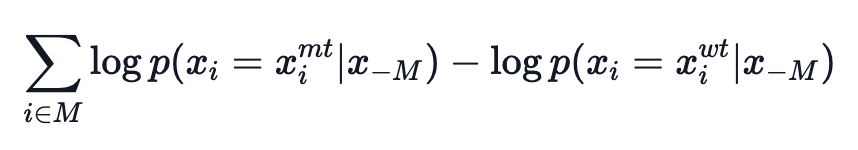

The idea here is that a protein that is more fit has higher probability, while a non function (less fitness) protein should have lower probability, where probability represents the probablity of the protein being found in the wild (and our training and test dataset). However, we will be working with log probabilites.

Write code to predict mutation effects using the ESM 8M model (from Hugging Face: https://huggingface.co/facebook/esm2_t6_8M_UR50D).

In [ ]:
def load_esm_model():
    """
    Loads the ESM2 model and tokenizer from Hugging Face and moves the model to GPU if available.

    This function initializes the "facebook/esm2_t6_8M_UR50D" model (designed for protein language
    modeling) and its tokenizer, then checks if a CUDA-compatible GPU is available. If so, it sends
    the model to the GPU to speed up computations; otherwise, it sticks with the CPU.

    Returns:
    - model: The ESM2 model ready for protein sequence tasks.
    - tokenizer: The tokenizer that processes protein sequences for the model.
    """
    model_name = "facebook/esm2_t6_8M_UR50D"
    model = EsmForMaskedLM.from_pretrained(model_name)
    tokenizer = EsmTokenizer.from_pretrained(model_name)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    return model, tokenizer

model, tokenizer = load_esm_model()

In [ ]:
def seq_to_esm_logits(sequence, mutation, model):
    """
    Computes the logits for a masked position in a protein sequence where a mutation is specified.

    This function modifies a given protein sequence by masking the amino acid at the position specified
    by the mutation. It then tokenizes this sequence using a pre-trained tokenizer and passes it to a
    pre-trained model to predict the logits (unnormalized log probabilities) for all possible amino acids
    at the masked position.

    Parameters:
    - sequence (str): The original protein sequence.
    - mutation (str): A string indicating the position and the new amino acid, e.g., 'A234B'.
                      The mutation format should be: original amino acid, position (1-based index), new amino acid.

    Returns:
    - logits (torch.Tensor): A tensor of shape (1, number of possible amino acids) containing the logits for
                             each amino acid at the masked position.

    Note:
    - The position in the mutation string is assumed to be 1-based, and Hugging Face tokenizer uses zero-indexing.
      The function automatically adjusts for this indexing difference.
    """
    pos = int(mutation[1:-1])
    # Convert sequence to a list to perform mutations
    sequence_list = list(sequence)

    # Mask the position where the mutation is to be applied
    sequence_list[pos - 1] = tokenizer.mask_token  # Using position-1 because Hugging Face uses zero-indexing
    masked_sequence = "".join(sequence_list)

    # Tokenize the sequence with the masked token
    inputs = tokenizer(masked_sequence, return_tensors="pt")

    # Move inputs to the same device as the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') ##copy device code from above if needed
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict the masked token probabilities
    with torch.no_grad():
        output = model(**inputs)

    # Get the logits for the masked token at the mutated position
    # this should be equivalent to pos - 1 here, but it is more flexible
    masked_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

    logits = output.logits[0, masked_index, :]
    return logits

Next, write a function to score a mutation to a given sequence.

In [ ]:
sequence = "MYSEQUENCE"
mutation = "Y2A"

def score_mutant_masked_marginal(sequence, mutation):
    """
    Calculates the effect of a mutation in a protein sequence using the masked marginal probability method.

    This function determines the effect of substituting one amino acid for another at a specific position
    in a protein sequence. It computes the logits for all possible amino acids at the mutated position
    using a pre-trained model. The function then converts these logits into probabilities and compares
    the probability of the original amino acid with that of the mutated amino acid to estimate the
    mutation's impact.

    Parameters:
    - sequence (str): The original protein sequence.
    - mutation (str): A string specifying the mutation, formatted as 'XnY', where 'X' is the original amino acid,
                      'n' is the position (1-based index), and 'Y' is the new amino acid.

    Returns:
    - mutation_effect (float): The log-ratio of the probabilities of the mutated amino acid to the original amino acid,
                               providing a measure of how the mutation affects the protein's fitness.

    The function outputs a positive value for a gain of function (mutant more likely than wild type) and a negative
    value for a loss of function (mutant less likely than wild type).
    """
    original_aa = mutation[0]
    pos = int(mutation[1:-1])
    mutated_aa = mutation[-1]

    logits = seq_to_esm_logits(sequence, mutation, model) ##CHANGED THIS LINE TO ADD MODEL
    print(f"Shape of logits: {logits.shape}")  #comment this out during the for loop

    ### COMPLETE HERE
    # Convert original and mutated amino acids to their token IDs
    original_aa_id = #
    mutated_aa_id = #

    # Get the softmax probabilities from the logits
    probabilities = #

    #Select probabilities (taken from logits) of original and mutated amino acids using their token ids ()
    original_prob = #
    mutated_prob = #

    # Compute the mutation effect: log-ratio of the probabilities
    mutation_effect = #

    return mutation_effect

score_mutant_masked_marginal(sequence, mutation)

Now, load the experimental data and score all single mutations in the AAV deep mutational scan. Our goal will be to compare the score made by ESM2 versus the experimental scores.

In [ ]:
def compute_esm_scores_for_mutations(experiment_data, background_sequence):
    """
    Computes ESM scores for each single mutation in the experimental data using a given background sequence.

    This function filters the experimental data to focus only on single mutations, computes ESM scores for each mutation,
    and appends these scores to the dataframe.

    Parameters:
    - experiment_data (pandas.DataFrame): The experimental data containing a column 'mutant' with mutation strings.
    - background_sequence (str): The background protein sequence used as the basis for mutation.

    Returns:
    - experiment_data (pandas.DataFrame): The modified DataFrame with an additional column 'esm_score' containing
                                          the computed ESM scores for each mutation.

    Usage:
    This function is specifically designed to handle data formats where mutations are denoted as single string entries
    in the 'mutant' column of the provided DataFrame. It requires the background sequence of the protein to be fully
    specified and expects that the sequence and mutations correspond accurately to each other.
    """
    # Filter for single mutations
    experiment_data["num_muts"] = experiment_data.mutant.str.split(":").str.len()
    experiment_single_muts = experiment_data[experiment_data.num_muts == 1]

    # List of all single mutations
    aav_mutations = experiment_single_muts.mutant.values

    # Compute ESM scores for each mutation
    esm_scores = [score_mutant_masked_marginal(background_sequence, mutation) for mutation in aav_mutations]

    # Append ESM scores to the DataFrame
    experiment_single_muts['esm_score'] = esm_scores

    return experiment_single_muts

# Load experimental data
experiment = pd.read_csv("aav_experiment.csv")

# Wild type AAV sequence used in experiment
aav_sequence = "MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLVLPGYKYLGPFNGLDKGEPVNEADAAALEHDKAYDRQLDSGDNPYLKYNHADAEFQERLKEDTSFGGNLGRAVFQAKKRVLEPLGLVEEPVKTAPGKKRPVEHSPVEPDSSSGTGKAGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGSGAPMADNNEGADGVGNSSGNWHCDSTWMGDRVITTSTRTWALPTYNNHLYKQISSQSGASNDNHYFGYSTPWGYFDFNRFHCHFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTQNDGTTTIANNLTSTVQVFTDSEYQLPYVLGSAHQGCLPPFPADVFMVPQYGYLTLNNGSQAVGRSSFYCLEYFPSQMLRTGNNFTFSYTFEDVPFHSSYAHSQSLDRLMNPLIDQYLYYLSRTNTPSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKDDEEKFFPQSGVLIFGKQGSEKTNVDIEKVMITDEEEIRTTNPVATEQYGSVSTNLQRGNRQAATADVNTQGVLPGMVWQDRDVYLQGPIWAKIPHTDGHFHPSPLMGGFGLKHPPPQILIKNTPVPANPSTTFSAAKFASFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYNKSVNVDFTVDTNGVYSEPRPIGTRYLTRNL"

# Compute ESM scores
experiment_scores = compute_esm_scores_for_mutations(experiment, aav_sequence)

#### 1.C.2 Question
Compute the correlation between the model scores (esm_score) and the experiments (DMS_score) and make a scatterplot. What do you observe? Is this the correlation that you expected? Hypothesize how you could make better predictions?

In [ ]:
def compare_scores(experiment_scores):
    """
    Generates a scatter plot to compare experimental DMS scores with model ESM scores and calculates
    the Spearman correlation between them.

    Parameters:
    - experiment_scores (pandas.DataFrame): DataFrame with columns 'DMS_score' for experimental scores and
      'esm_score' for model scores.

    Returns:
    - float: The Spearman correlation coefficient indicating the relationship between the two score sets.
    """
    pass

**ANSWER**:

#### 1.C.3 Question
Let's generate a multiple sequence alignment (MSA) for AAV. In a multiple sequence alignment, homologous residues among a set of sequences are aligned together in columns. MSAs are used for traditional method to learn mutation effects by analyzing the probability of different mutations in the set of homologous or evolutionary-related sequences.







We have provided an alignment for AAV (aav_alignment.a2m), but you can also try to generate your own alignment!

The steps to generate an alignment would be 1) using JackHMMer to search for homologous sequences and 2) Using Clustal Omega to align the sequences.

1) Use JackHMMER to Search UniProtKb
JackHMMER performs iterative sequence searches and builds alignments by finding homologous sequences in databases like UniProtKB.

Go to the JackHMMER search page at the European Bioinformatics Institute (EBI): https://www.ebi.ac.uk/Tools/hmmer/search/jackhmmer

Enter your protein sequence in FASTA format:
  
    >AAV
    MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLVLPGYKYLGPFNGLDKGEPVNEADAAALEHDKAYDRQLDSGDNPYLKYNHADAEFQERLKEDTSFGGNLGRAVFQAKKRVLEPLGLVEEPVKTAPGKKRPVEHSPVEPDSSSGTGKAGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGSGAPMADNNEGADGVGNSSGNWHCDSTWMGDRVITTSTRTWALPTYNNHLYKQISSQSGASNDNHYFGYSTPWGYFDFNRFHCHFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTQNDGTTTIANNLTSTVQVFTDSEYQLPYVLGSAHQGCLPPFPADVFMVPQYGYLTLNNGSQAVGRSSFYCLEYFPSQMLRTGNNFTFSYTFEDVPFHSSYAHSQSLDRLMNPLIDQYLYYLSRTNTPSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKDDEEKFFPQSGVLIFGKQGSEKTNVDIEKVMITDEEEIRTTNPVATEQYGSVSTNLQRGNRQAATADVNTQGVLPGMVWQDRDVYLQGPIWAKIPHTDGHFHPSPLMGGFGLKHPPPQILIKNTPVPANPSTTFSAAKFASFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYNKSVNVDFTVDTNGVYSEPRPIGTRYLTRNL

Select UniProtKB as the target database.

JackHMMER will iteratively search for homologous sequences in the target database.

After each iteration, JackHMMER will display homologous sequences found in the target database, ranked by e-value (sequence similarity score).
You can adjust the number of iterations to get more homologous sequences if needed.

Once the search is complete, you can download the aligned sequences in FASTA format by selecting the option to export them.

2)  After retrieving homologous sequences, you can align them to your target sequence using an MSA tool such as Clustal Omega.

Go to Clustal Omega at EBI: https://www.ebi.ac.uk/jdispatcher/msa/clustalo

Paste the target sequence along with the sequences retrieved from JackHMMER into the sequence input box.

Click "Submit" to run the multiple sequence alignment.

Once the MSA is completed, you can download the aligned sequences in various formats (e.g., FASTA, Clustal format).

**BONUS ANSWER**: (Upload images of your outputs from JackHMMER and Clustal)

#### 1.C.4 Question

Let's compute an Position Site Score Matrix (PSSM) from either the provided or your generated alignment. A PSSM is the frequency (probability) of each amino acid at each position in the alignment. Amino acids that aren't in the alignment at that position are given low (negative) scores. Note if you are going to use your own alignment, you must remove any columns that are positions not present in the given AAV sequence (or indexing will be off).

In [ ]:
def generate_pssm_and_update_experiment(msa_file, experiment_data, **kwargs):
    """
    This function processes an MSA to compute the frequency of each amino acid at each position in the alignment,
    ignoring non-amino acid characters. It then computes a score for each mutation in the experimental data based
    on the PSSM and updates the DataFrame with these scores.

    Notes: 1) Load the Multiple Sequence Alignment (MSA) file (aav_alignment.a2m).
    2) Ignore characters "-" and "X" (or others if needed that aren't amino acids)
    3) Add mutation effect PSSM scores into the experimental data frame for all mutations in the AAV experiment
    4) Can use Biopython or calculate frequencies yourself (in biopython, you can use the "fasta" type for this "a2m" alignment)

    Parameters:
    - msa_file (str): Path to the file containing the MSA data, typically in .a2m or similar format.
    - experiment_data (pandas.DataFrame): DataFrame containing experimental data with a column for mutations.

    Returns:
    - pandas.DataFrame: Updated DataFrame including a new column with PSSM scores for each mutation.
    """
    pass

Compute the correlation between the model scores (PSSM) and the experiments (DMS_score) and make a scatterplot. What do you observe? Which model better predicts the experimental data? Is this what you expected? What problems may PSSMs have?

In [ ]:
def compare_dms_pssm_scores(experiment_scores, **kwargs):
    """
    Create scatterplot comparing single mutation experiment dms scores and model PSSM scores.
    Calculate spearman between experiment dms scores and model PSSM scores

    Parameters:
    - experiment_scores (pandas.DataFrame): DataFrame containing 'DMS_score' for experimental scores
      and 'pssm_score' for model predictions.

    Returns:
    - float: Spearman correlation coefficient, quantifying the degree to which the model predictions
      are associated with the experimental results.
    """
    pass

**ANSWER**:


## 2. Structure Prediction

In this problem, you will predict the structure of the AAV protein using both AlphaFold2 and AlphaFold3. Use the wild-type sequence from 1.C.3.



#### 2.A.1 Question

Run your protein through AlphaFold2 using this notebook:
https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb

All you need to do is paste in your sequence from above and run all the cells. No need to modify any of the parameters. See the part that says:  
`Input protein sequence(s), then hit Runtime -> Run all`

This may take up to an hour to complete. Once done, take a screenshot of the predicted structure and download results. The external notebook downloads zip file `jobname.result.zip` to your system. On extracting, among many other files, there are a sequence of PDB files out of which the one that is first generated can be uploaded. It will look something like this:  
`<job_name>_unrelaxed_rank_005_alphafold2_ptm_model_1_seed_000.pdb`

Upload any of the pdb files and the screenshot into this notebook using the files tab to the left. There's a button to upload files. Once uploaded you should press `copy file path` to get the correct paths for your uploads (they usually live under the `/content/` directory).

Display you screenshot and load the pdb using the code provided.

In [ ]:
def load_pdb_file(file_name):
  """
  Load a PDB file and extract the structure, amino acid sequence, and coordinates of the alpha carbons.

  This function only processes the first model and the chain with ID 'A' from the PDB file.

  Parameters:
  file_name (str): The path to the PDB file to be loaded.

  Returns:
  tuple:
      - Bio.PDB.Structure.Structure: The complete structure as parsed from the file.
      - str: The sequence of amino acids from chain A.
      - numpy.ndarray: The coordinates of the alpha carbons in chain A.
    """
  pdbp = PDBParser()
  struct = pdbp.get_structure("struct", file_name)
  model = struct[0]

  sequence = []
  coords = []
  for chain in model:
    if chain.id != "A":
      continue
    for residue in chain:
      coords.append(residue['CA'].get_vector().get_array())
      resname = AA_NAME_MAP[residue.resname]
      sequence.append(residue.resname)

  return struct, "".join(sequence), np.array(coords)

def display_image(file_name):
  """
  Parameters:
  file_name (str): The path to the image file to be displayed.

  Returns:
  IPython.core.display.Image: An image object that can be displayed in an IPython notebook.
  """
  return Image(filename=file_name)

# COMPLETE HERE
# load your structure & display the plot you downloaded
# to get the correct path for your file, select it and press "copy path"
af2_coords = #

#### 2.A.2 Question

Now fold the same sequence using AlphaFold3.

You can use this link: https://alphafoldserver.com/about.

Once you're done, take a screenshot of the predicted structure and download the PDB file. Upload both files again as you did in the previous problem, display the image here and load the pdb coordinates using the `load_pdb_file` above.

In [ ]:
### COMPLETE HERE
af3_coords = #

#### 2.A.3 Question

Now we will compare the two predictions. For this, you will compute the RMSD. Recall the RMSD:

$$ f(x, y) = \frac{1}{N} \sum_{i=1}^N ||x_i - y_i||^2  \\
RMSD(x, y) = \sqrt{f(x, y)} $$


First we will align the two structures and then we will compute the deviation. What is the RMSD between your two predicted structures? Do the models seem to agree?

In [ ]:
def compute_rmsd(coords1, coords2):
    """
    Calculate the root-mean-square deviation (RMSD) after optimal superposition.

    This function aligns the second set of coordinates onto the first using the
    Singular Value Decomposition (SVD) method provided by the SVDSuperimposer class,
    and computes the RMSD between them.

    Parameters:
    coords1 (numpy.ndarray): The reference coordinate set as a NxD numpy array,
                             where N is the number of points and D is the dimensionality.
    coords2 (numpy.ndarray): The coordinate set to align as a NxD numpy array,
                             matching the dimensions of coords1.

    Returns:
    float: The computed RMSD value indicating the average distance between all pairs
           of corresponding points after optimal superposition.
    """
    sup = SVDSuperimposer()
    sup.set(coords1, coords2)
    sup.run()
    rms = sup.get_rms()
    return rms

print(compute_rmsd(af2_coords, af3_coords))

**ANSWER**:

Take a look at the contact maps for each of your two structures. A protein contact map represents the distance between all possible amino acid residue pairs of a three-dimensional protein structure using a binary two-dimensional matrix M. For two residues
i and j, the M[i,j] is 1 if the two residues are closer than a predetermined distance threshold, and 0 otherwise. Note that the points are very light on the contact map.

In [ ]:
def calculate_contact_map(structure, distance_threshold=5.0):
    """
    Calculates the contact map for a given structure based on distance between C-alpha atoms.

    Parameters:
    structure: Parsed protein structure.
    distance_threshold (float): Threshold distance to consider residues as being in contact.

    Returns:
    contact_map (2D array): Contact map matrix where 1 represents contact and 0 represents no contact.
    """
    model = structure[0]  # Use first model of the structure
    atoms = [residue['CA'] for chain in model for residue in chain if residue.has_id('CA')]

    # Initialize a contact map of size (number of atoms) x (number of atoms)
    num_atoms = len(atoms)
    contact_map = np.zeros((num_atoms, num_atoms))

    # Calculate pairwise distances and fill the contact map
    for i, atom1 in enumerate(atoms):
        for j, atom2 in enumerate(atoms):
            distance = atom1 - atom2  # Distance between two atoms
            if distance < distance_threshold:
                contact_map[i][j] = 1

    return contact_map

In [ ]:
def plot_contact_map(contact_map, title):
    """
    Plots the contact map using Matplotlib.

    Parameters:
    contact_map (2D array): The contact map to be plotted.
    title (str): Title of the plot.
    """
    plt.imshow(contact_map, cmap='Greys', interpolation='nearest')
    plt.title(title)
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.colorbar(label='Contact (1=Yes, 0=No)')
    plt.show()

Do the models predict the same or different contacts?

**ANSWER**:

#### 2.A.4 Question

Look at the model mutation effect predictions (from ESM and PSSM) on surface of your AF3 protein structure. You will need to download Pymol (https://www.pymol.org/) as well as your protein structures locally (to match the pdb_file name outputted to the pml file). This code outputs a pml file that is run within Pymol.

In [ ]:
def export_mutability_to_pymol(mutability_scores, pdb_file, output_file="mutability_scores.pml"):
    """
    Exports mutability scores to a PyMOL script that can color the structure by mutability.

    Parameters:
    mutability_scores (dict): Dictionary of residue positions and their mutability scores.
    pdb_file (str): Path to the PDB file of the protein structure locally (to load into pymol).
    output_file (str): Path to the PyMOL script file (default is "mutability_scores.pml").
    """
    with open(output_file, 'w') as f:
        f.write(f"load {pdb_file}\n")
        f.write(f"color grey\n")

        for residue_index, mutability_score in mutability_scores.items():
            # Generate PyMOL coloring commands based on mutability scores
            color_value = mutability_score  # Scale these scores as needed
            f.write(f"set_color res_{residue_index}_color, [{color_value}, {1 - color_value}, 0]\n")
            f.write(f"color res_{residue_index}_color, resi {residue_index}\n")

        f.write("show cartoon\n")
        f.write("bg_color white\n")
        f.write("set cartoon_transparency, 0.3\n")
        f.write("zoom\n")

    print(f"PyMOL script saved to {output_file}. Run the script in PyMOL to visualize mutability.")


###COMPLETE HERE
#Your mutability scores are a dict of your position-averaged PSSM or ESM scores
#you should scale your mutability scores to be between 0 and 1
#from experiment_single_muts for each position as the key

Looking at the protein, what can you say about where it is more mutable? What information does this tell you that is different than looking how mutability changes across the primary sequence?


**ANSWER**: (upload 2 images from pymol, one for PSSM and one for ESM)

**ANSWER**:

Plot also the DMS scores on the surface. What can you say about where prediction differ from the model scores?

In [ ]:
###COMPLETE HERE

**ANSWER**: (upload image from pymol)

**ANSWER**:

## 3. Active Learning

We are going to follow the few-shot active learning framework from https://www.biorxiv.org/content/10.1101/2024.07.17.604015v1.full.

1) selecting a random set of first-round variants

2) employing a regressor discriminatory model to predict protein activities of all AAV mutations from the same dataset above (the paper here uses a random forest, but feel free to experiment with other models too!)

3) using residue pooled average final embeddings from ESM (you can use the same ESM 8M parameter model) as input to your model output the predicted fitness of each variant (or your choice of other embedding from ESM!)

4) using a top-15 selection strategy in each round of evolution to add to your new training set for your model and re-train.

The AAV experimental data (experimental_single_muts) used above is your oracle of how the mutations you tested actually perform (get the experimental values for the mutations your model tells you to experimentally test).

Report your best performing mutant after 5 rounds of experiments and re-training.

In [ ]:
# Initial random selection of mutation candidates
mutation_candidates = []
random_selected = np.random.choice(experiment_single_muts["mutant"], 15, replace=False)
print(f"Randomly selected mutations for Round 1: {random_selected}")

Get the residue pooled average ESM embedding from one of the ESM models used above.

In [ ]:
# Function to compute the ESM embedding for each mutation
def get_features(mutation):
    pos = int(mutation[1:-1])  # Extract position from mutation (e.g., K10R -> 10)
    original_aa = mutation[0]
    mutated_aa = mutation[-1]

    ###COMPLETE HERE
    # ESM embedding
    #use the ESM model to get a 1D vector ESM embedding (from ESM final layer)
    #average across all positions for your sequence with that mutation
    return esm_embedding

# Get features and labels (DMS experimental values) for Round 1
X_round1 = np.array([get_features(mut) for mut in random_selected])
y_round1 = np.array([experiment_single_muts[experiment_single_muts["mutant"] == mut]["DMS_score"] for mut in random_selected])

You will now train a regressor model, such as a random forest, to predict mutation performance using the features generated from ESM embeddings. You can use a regressor from sklearn such as: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html.

In [ ]:
#Train a regressor model on your first round of data

###COMPLETE HERE
# Train a regression model (random forest or other model)
model = #

#fit model on X_round1, y_round1


For each round of active learning, predict mutation performance for all candidate mutations, select the top-15 mutations with the highest predicted scores, and add these to the training set. You will train a regressor model, such as a random forest, to predict mutation performance using the features generated from ESM embeddings.

In [ ]:
# Function to select top-N mutations based on predicted model scores
def select_top_n(model, X, mutation_candidates, n=15):
  ###COMPLETE HERE

# Active learning loop for 5 rounds
n_rounds = 5
all_mutation_candidates = list(experiment_single_muts["mutant"])  # All available mutation candidates
selected_mutations = random_selected.tolist()

for round_num in range(2, n_rounds + 1):
    print(f"\nRound {round_num}")

    # Get features for all remaining mutations
    remaining_mutations = [mut for mut in all_mutation_candidates if mut not in selected_mutations]
    X_remaining = np.array([get_features(mut) for mut in remaining_mutations])

    # Predict performance for remaining mutations
    top_15_mutations = select_top_n(model, X_remaining, remaining_mutations, n=15)
    selected_mutations.extend(top_15_mutations)

    # Add the top 15 to the training set
    #These are the experiments that were run as a result of your model
    X_top15 = np.array([get_features(mut) for mut in top_15_mutations])
    y_top15 = np.array([experiment_single_muts[experiment_single_muts["mutant"] == mut]["DMS_score"] for mut in top_15_mutations])

    ###COMPLETE HERE
    # Combine with all previous training data and re-train the same regressor model

    #what was the experimental DMS_score of your best-performing mutant in your top 15 experiment?


What was the best-performing mutation after each round of experiments? Did their scores increase over the 5 rounds? (only look at the experimental values of the tested mutations)?

How does active learning help reduce the number of mutations tested experimentally? Consider whether active learning manages to identify the most fit single mutation from the deep mutational scan?

**ANSWER**: